In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler
from sklearn.pipeline import Pipeline
from util import Util
from cost_data_manager import CostDataManager
from matplotlib.backends.backend_pdf import PdfPages

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 

excel_file_video = r"video_dataset_with_costs(cost).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(cost).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video


cost_labels = [
                'Century Link', 
                'Google', 
                'Azure', 
                'Amazon', 
                'Oracle', 
                'Alibaba', 
                'DigitalOcean'
             ]
used_features = ['Users',
                 'Max CPU utilization (%)',
                 'NW Egress (GB)',
                 'Avg RAM used (MB)',
                 'Used storage(image size, GB)'
                ] 
outcome_label = 'cost'
############################################################

dataManager = CostDataManager(excel_file, outcome_label, cost_labels, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()  

def transformX(X):
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X)
    X = pd.DataFrame(X1, columns=X.columns)      
    return X

def transformY(Y):
    return Y
    #data = Y.copy().values
    #data = np.sqrt(data)
    #ret = pd.Series(data)
    #return ret 
def invTrans(X):
    return X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

sve_metrike = dataManager.getAllMetrics()
m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

print("\n")
print("Sve metrike")
for metrika in sve_metrike:
    print(metrika)
print("\n")
print("All metrike")
for metrika in m_all:
    print(metrika)
print("\n")
print("Large metrike")
for metrika in m_large:
    print (metrika)
print("\n")

working_metrics = m_large
working_metrics_label = "large"
print("Total working data:", len(working_metrics))
util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


0 Century Link
1 Google
2 Azure
3 Amazon
4 Oracle
5 Alibaba
6 DigitalOcean
12 features removed (std +/- 3) -  all
7 features removed (std +/- 3) -  large
7 features removed (std +/- 3) -  medium
21 features removed (std +/- 3) -  small

COST
0        530.221737
1       4551.806759
2       6069.014745
3       7722.316874
4       9249.843030
5      10933.576904
6      12518.687140
7      14174.159494
8      15798.929082
9      17435.012500
10     26842.244122
11     28647.421053
12     30400.106166
13     32157.228895
14     33972.047920
15     35864.270908
16       432.183004
17      1621.280223
18      3173.265154
19      6288.579872
20      7833.274069
21     10806.221632
22     12451.849725
23     14083.496768
24     15722.018540
25     17309.536566
26     20692.920373
27     22366.492631
28     24009.724619
29     25765.211888
           ...     
301      648.485031
302     1271.547974
303     1580.486814
304     2175.076326
305     2504.201945
306     2830.531354
307     3158.23570

## Correlogram

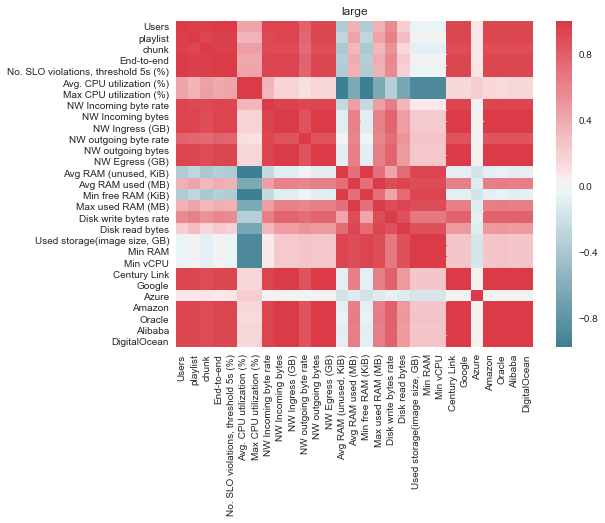

In [3]:
from matplotlib.backends.backend_pdf import PdfPages

writer_report = pd.ExcelWriter(report_directory + "/" + "cost" + '_report.xlsx', engine='xlsxwriter')

with PdfPages(report_directory + "/" + "cost" + '_graphs_correlogram.pdf') as pdf:
    #metrics = working_metrics
    metrics = sve_metrike
    # correlation matrix visuals 1
    f, ax = plt.subplots(figsize=(8, 6))

    # methods: {‘pearson’, ‘kendall’, ‘spearman’}
    corr = metrics.corr(method='spearman')
    #print("\nAtributi metrika")
    #for atrib in dir(metrics):
    #    print (atrib)
    #print("\n")
    sns_plot = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))
    ax.set_title(working_metrics_label)
    #plt.savefig(prefix + "_corr.png",  bbox_inches = 'tight')
    pdf.savefig(bbox_inches = 'tight')
    plt.show()
    plt.close()
    # output of parameters
    prefix = working_metrics_label
    metrics.describe().to_excel(writer_report, sheet_name = prefix + "_description")
    metrics.corr().to_excel(writer_report, sheet_name = prefix + "_corr")
    metrics.cov().to_excel(writer_report, sheet_name = prefix + "_cov")
    writer_report.save()
    writer_report.close()

# Feature selection

## VIF 

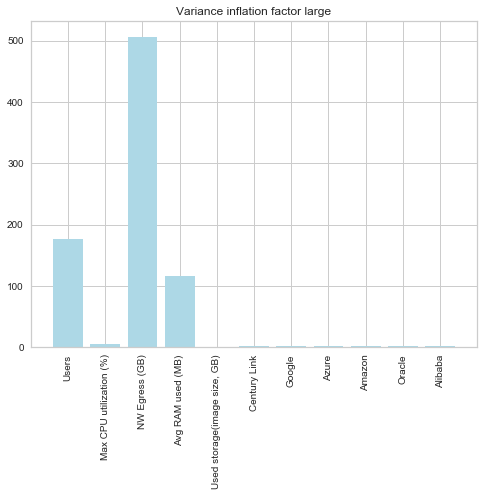

,index,VIF
2,NW Egress (GB),506.615155
0,Users,177.058510
3,Avg RAM used (MB),116.101475
1,Max CPU utilization (%),4.997992
7,Azure,1.838147
9,Oracle,1.774587
6,Google,1.724951
10,Alibaba,1.666840
5,Century Link,1.615691
8,Amazon,1.608096


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import cross_validation
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

vif = [variance_inflation_factor(X_train.values, j) for j in range(X_train.shape[1])]

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variance inflation factor ' + working_metrics_label)

ax.bar(range(X.shape[1]), vif, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

VIF = pd.DataFrame(vif, columns =["VIF"], index=X.columns)
VIF = VIF.reset_index()
VIF.sort_values(['VIF'],ascending=0)

## Variable Importance

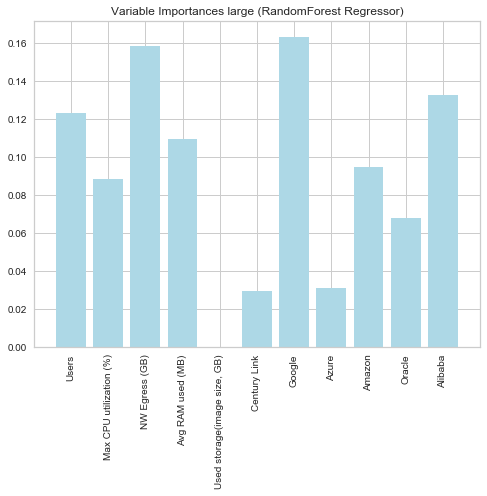

,index,RandomForest
6,Google,0.163521
2,NW Egress (GB),0.158735
10,Alibaba,0.133065
0,Users,0.123237
3,Avg RAM used (MB),0.109392
8,Amazon,0.094681
1,Max CPU utilization (%),0.088460
9,Oracle,0.067949
7,Azure,0.031260
5,Century Link,0.029699


In [4]:
from sklearn.ensemble import RandomForestRegressor

X,Y = dataManager.getXY_panda(working_metrics)
model = RandomForestRegressor(n_estimators=200, random_state=1)
model.fit(X, Y)
importances = model.feature_importances_

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variable Importances ' + working_metrics_label + ' (RandomForest Regressor)')

ax.bar(range(X.shape[1]), importances, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

VI = pd.DataFrame(model.feature_importances_, columns = ["RandomForest"], index=X.columns)
VI = VI.reset_index()
VI.sort_values(['RandomForest'],ascending=0)

## Recursive Feature Elimination

In [5]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X,Y = dataManager.getXY_panda(working_metrics)
model = LinearRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, Y)

Selected = pd.DataFrame(rfe.support_, columns = ["RFE"], index=X.columns)
Selected = Selected.reset_index()
Selected

,index,RFE
0,Users,True
1,Max CPU utilization (%),True
2,NW Egress (GB),True
3,Avg RAM used (MB),True
4,"Used storage(image size, GB)",True
5,Century Link,True
6,Google,True
7,Azure,True
8,Amazon,True
9,Oracle,True


## Variable Importance - Extratrees Regressor

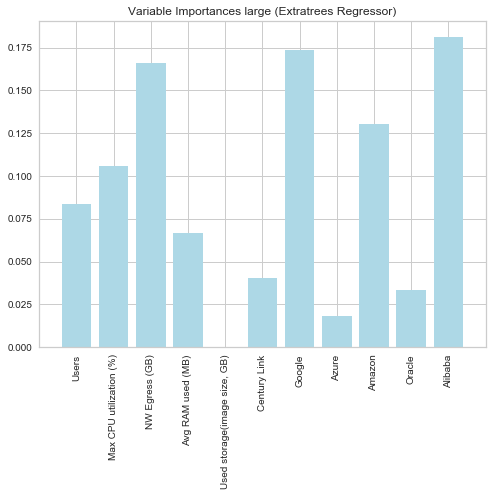

,index,Extratrees
10,Alibaba,0.181356
6,Google,0.173313
2,NW Egress (GB),0.166046
8,Amazon,0.130464
1,Max CPU utilization (%),0.106045
0,Users,0.083826
3,Avg RAM used (MB),0.066904
5,Century Link,0.040363
9,Oracle,0.033549
7,Azure,0.018134


In [6]:
from sklearn.ensemble import ExtraTreesRegressor

X,Y = dataManager.getXY_panda(working_metrics)

model = ExtraTreesRegressor()
model.fit(X, Y)

importances = model.feature_importances_
names = X.columns.values

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variable Importances ' + working_metrics_label + ' (Extratrees Regressor)')

ax.bar(range(X.shape[1]), importances, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

FI = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=X.columns)
FI = FI.reset_index()
FI.sort_values(['Extratrees'],ascending=0)

## L1 feature selection 

In [7]:
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel

X,Y = dataManager.getXY_panda(working_metrics)

lsvr = LinearSVR(random_state=0).fit(X, Y)
model = SelectFromModel(lsvr,prefit=True)
l1 = pd.DataFrame(model.get_support(), columns = ["L1"], index=X.columns)
l1 = l1.reset_index()
l1

,index,L1
0,Users,False
1,Max CPU utilization (%),True
2,NW Egress (GB),False
3,Avg RAM used (MB),True
4,"Used storage(image size, GB)",False
5,Century Link,False
6,Google,False
7,Azure,False
8,Amazon,False
9,Oracle,False


## Feature selection combined

In [8]:
from functools import reduce
dfs = [VIF, VI, Selected, FI, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
final_results

,index,VIF,RandomForest,RFE,Extratrees,L1
0,Users,177.058510,0.123237,True,0.083826,False
1,Max CPU utilization (%),4.997992,0.088460,True,0.106045,True
2,NW Egress (GB),506.615155,0.158735,True,0.166046,False
3,Avg RAM used (MB),116.101475,0.109392,True,0.066904,True
4,"Used storage(image size, GB)",NaN,0.000000,True,0.000000,False
5,Century Link,1.615691,0.029699,True,0.040363,False
6,Google,1.724951,0.163521,True,0.173313,False
7,Azure,1.838147,0.031260,True,0.018134,False
8,Amazon,1.608096,0.094681,True,0.130464,False
9,Oracle,1.774587,0.067949,True,0.033549,False
